# Image caption generator
## Description
In this project, we extract features from the images using pre-trained VGG16 model, and then feed to the LSTM model along with the captions to train. The trained model has the ability to generate captions for any images that are fed to it.
## Dataset
The dataset used in this project is [FLICKR 8K](https://forms.illinois.edu/sec/1713398), which consists of around 8091 images along with 5 captions for each image. For a more powerful system with more than 16GB RAM and a graphic card with more than 4GB of memory, [FLICKR 30K](http://bryanplummer.com/) is worth trying.
## Dependencies
- Keras
- Tensorflow GPU
- Pre-trained VGG16 weights
- NLTK
- Matlplotlib

In [1]:
import sys, os, time,warnings
import tensorflow as tf
import keras 
from keras.backend.tensorflow_backend import set_session
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

warnings.filterwarnings("ignore") # never print matching warnings in a list
print("Python: {}".format(sys.version))
print("keras: {}".format(keras.__version__))
print("numpy: {}".format(np.__version__))
print("pandas: {}".format(pd.__version__))
print("tensorflow: {}".format(tf.__version__))
print("matplotlib: {}".format(matplotlib.__version__))

Python: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
keras: 2.2.4
numpy: 1.16.2
pandas: 0.24.2
tensorflow: 1.13.1
matplotlib: 3.0.3


Using TensorFlow backend.


## Configuring the GPU memory for training

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95 # using 95% available memory of the GPU
config.gpu_options.visible_device_list = "0" # only see the GPU 0

set_session(tf.Session(config=config))

# function to set seed 
def set_seed(sd=42):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    
    # numpy random seed
    seed(sd)
    # core python's random number
    rn.seed(sd)
    # tensorflow's random number
    set_random_seed(sd)

## Load the image dataset and its corresponding captions

In [3]:
# location of Flickr8K_ images
dir_flickr_jpg = "Flicker8k_Dataset/"

# location of the caption file
dir_flickr_text = "Flickr8k_text/Flickr8k.token.txt"

# examine the number of images in the dataset
jpgs = os.listdir(dir_flickr_jpg)
print("The number of images in Flickr8K: {}".format(len(jpgs)))

The number of images in Flickr8K: 8091


In [4]:
# find the captions corresponding to each image
file = open(dir_flickr_text, 'r', encoding='utf8')
text = file.read()
file.close()

datatxt = []
# loop over each line in text to get the captions
# example of one line: 1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
for line in text.split('\n'):
    col = line.split('\t') # get [1000268201_693b08cb0e.jpg#1, A girl going into a wooden building .]
    if len(col) == 1: # ignore if len(col) == 1
        continue
    w = col[0].split("#") # get  [1000268201_693b08cb0e.jpg, 1]
    datatxt.append(w + [col[1].lower()]) # [[1000268201_693b08cb0e.jpg, 1, a girl going into a wodden building .], ...]
    
df_text = pd.DataFrame(datatxt, columns=["filename", "index", "caption"])

# get unique filenames
unique_filenames = np.unique(df_text.filename.values)
print("The number of unique file names: {}".format(len(unique_filenames)))
print("The distribution of the number of captions for each image: ")
Counter(Counter(df_text.filename.values).values())
print(df_text[:5])

The number of unique file names: 8092
The distribution of the number of captions for each image: 
                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  a child in a pink dress is climbing up a set o...  
1              a girl going into a wooden building .  
2   a little girl climbing into a wooden playhouse .  
3  a little girl climbing the stairs to her playh...  
4  a little girl in a pink dress going into a woo...  


## Examine few images and their captions

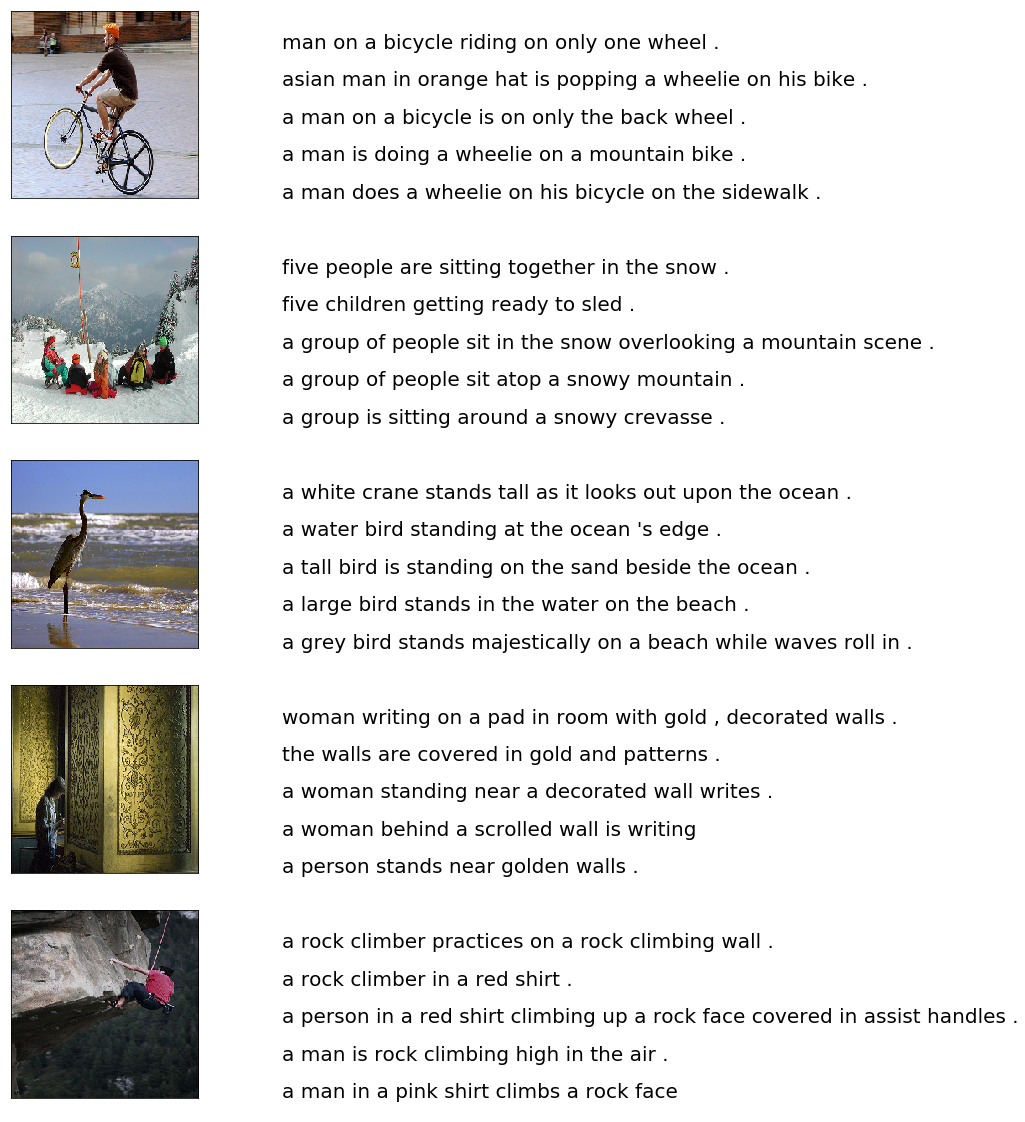

In [5]:
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import display
from PIL import Image

num_imgs = 5 # display 5 imgs from the dataset
num_pixels = 224 # define size of each image
target_size = (num_pixels, num_pixels, 3)

count = 1
fig = plt.figure(figsize=(10, 20))

for jpgfnm in unique_filenames[-5:]:
    filename = dir_flickr_jpg + '/' + jpgfnm
    captions = list(df_text["caption"].loc[df_text["filename"]==jpgfnm].values)
    img_load = load_img(filename, target_size=target_size)
    
    # params for plt
    ax = fig.add_subplot(num_imgs, 2, count, xticks=[], yticks=[])
    ax.imshow(img_load)
    count += 1
    
    ax = fig.add_subplot(num_imgs, 2, count)
    plt.axis('off') # disable axis title
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    count += 1
    
plt.show()

## Cleaning captions for further analysis

In [6]:
# function to calculate the top 3 words in all the captions available for the images
def df_word(df_text):
    vocab = []
    for txt in df_text.caption.values:
        vocab.extend(txt.split()) # add each word to vocab
    print("Vocabulary size: {}".format(len(set(vocab))))
    ct = Counter(vocab)
    dfword = pd.DataFrame({"word": list(ct.keys()), "count": list(ct.values())})
    dfword = dfword.sort_values("count", ascending=False)
    dfword = dfword.reset_index()[["word", "count"]] # reset index for df after sorting
    
    return dfword

dfword = df_word(df_text)
dfword.head()

Vocabulary size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975
3  the  18419
4   on  10744

## Cleaning captions for further processing
The captions in the dataset contains punctuations, singular words and numerical values that need to be cleaned before they are fed into the model.

In [7]:
import string

text_original = "I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?"
print(text_original)

# remove punctuation
def remove_puntuation(text_original):
    text_wo_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))
    
    return text_wo_punctuation

text_wo_punctuation =  remove_puntuation(text_original)
print("\nText without punctuation: {}".format(text_wo_punctuation))

# remove a single character word
def remove_single_character(text):
    text_len_more_than_one = ""
    
    for word in text.split():
        if len(word) > 1:
            text_len_more_than_one += " " + word
    
    return text_len_more_than_one

text_len_more_than_one = remove_single_character(text_wo_punctuation)
print("\nText without a single character: {}".format(text_len_more_than_one))

# remove words with numerical values
def remove_numeric(text, printTF=False):
    text_wo_numeric = ""
    for word in text.split():
        isalpha = word.isalpha() # check it word containing alphabetic character only
        if printTF: # if print True/False alphabetic is chosen
            print("   {:10}:  {:}".format(word, isalpha))
        if isalpha:
            text_wo_numeric += " " + word
    
    return text_wo_numeric

text_wo_numertic = remove_numeric(text_len_more_than_one, printTF=True)
print("\nText without numeric: {}".format(text_wo_numertic))

I ate 1000 apples and a banana. I have python v2.7. It's 2:30 pm. Could you buy me iphone7?

Text without punctuation: I ate 1000 apples and a banana I have python v27 Its 230 pm Could you buy me iphone7

Text without a single character:  ate 1000 apples and banana have python v27 Its 230 pm Could you buy me iphone7
   ate       :  True
   1000      :  False
   apples    :  True
   and       :  True
   banana    :  True
   have      :  True
   python    :  True
   v27       :  False
   Its       :  True
   230       :  False
   pm        :  True
   Could     :  True
   you       :  True
   buy       :  True
   me        :  True
   iphone7   :  False

Text without numeric:  ate apples and banana have python Its pm Could you buy me


In [8]:
def text_clean(text_original):
    text = remove_puntuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    
    return text

for i, caption in enumerate(df_text.caption.values):
    cleaned_caption = text_clean(caption)
    df_text["caption"].iloc[i] = cleaned_caption

## Plotting the top 50 words that appear in the cleaned dataset

Vocabulary size: 8763


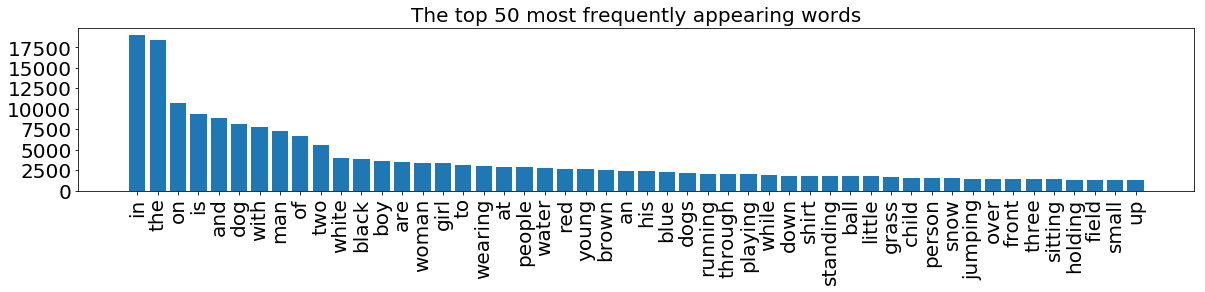

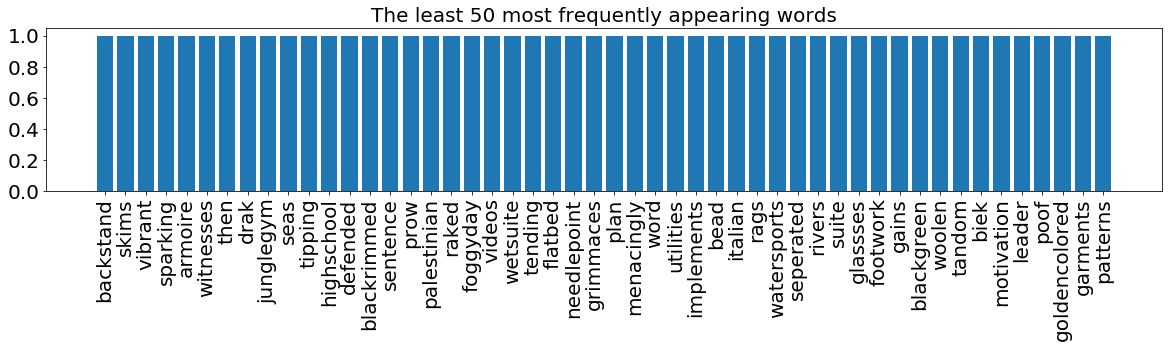

In [9]:
num_top = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index, dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index, dfsub["word"], rotation=90, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()
    
dfword = df_word(df_text)
plthist(dfword.iloc[:num_top, :],
       title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-num_top:, :],
       title="The least 50 most frequently appearing words")

## Adding start and end sequence tokens for each captions
**startseq**, and **endseq** has to be added to the tokens, so that it's easier to identify the captions for the images since each of them in a different length.

In [11]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_text)
df_txt0["caption"] = add_start_end_seq_token(df_text["caption"])

del df_text

In [12]:
df_txt0[:5]

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  startseq  child in pink dress is climbing up s...  
1   startseq  girl going into wooden building endseq  
2  startseq  little girl climbing into wooden pla...  
3  startseq  little girl climbing the stairs to h...  
4  startseq  little girl in pink dress going into...

## Load VGG16 model and weights to extract features from images
The pre-trained weights for VGG16 model can be downloaded from [here](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5).

In [13]:
from keras.applications import VGG16

model_vgg = VGG16(include_top=True, weights=None) # include 3 fc layers on top of the network
model_vgg.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
model_vgg.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

## Delete the last layer of the model
The last layer of VGG16 will be excluded because we just want to utilize VGG16 to do feature extraction rather than classification

In [14]:
from keras import models

model_vgg.layers.pop()
model_vgg = models.Model(inputs=model_vgg.inputs, outputs=model_vgg.layers[-1].output)

# summary the model
model_vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
import gc
gc.collect()

125

## Feature extraction 
Let's now extract features from all the images in the dataset. VGG16 generates 4096 features from the input image of 224\*224.

In [16]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

imgs = OrderedDict()
num_pixels = 224 # fixed size since VGG16 was trained with input images of the same size
target_size = (num_pixels, num_pixels, 3)
data = np.zeros((len(jpgs), num_pixels, num_pixels, 3))

for i, name in enumerate(jpgs):
    # load an image from file
    filename = dir_flickr_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    
    # convert the image pixels into a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image) # format the image to required image format for the model, i.e., (224, 224, 3)
    
    y_pred = model_vgg.predict(nimage.reshape( (1, ) + nimage.shape[:3]), verbose=0) # convert shape to (1, 224, 224, 3)
    imgs[name] = y_pred.flatten() # flatten to (150528, )

In [17]:
import gc
gc.collect()

20

## Plotting similar images from the dataset
We are going to use PCA to reduce the dimensions of the features generate from VGG16 feature extraction from 4096 to 2.

In [18]:
from sklearn.decomposition import PCA

encoder = np.array(list(imgs.values()))

pca = PCA(n_components=2)
y_pca = pca.fit_transform(encoder)

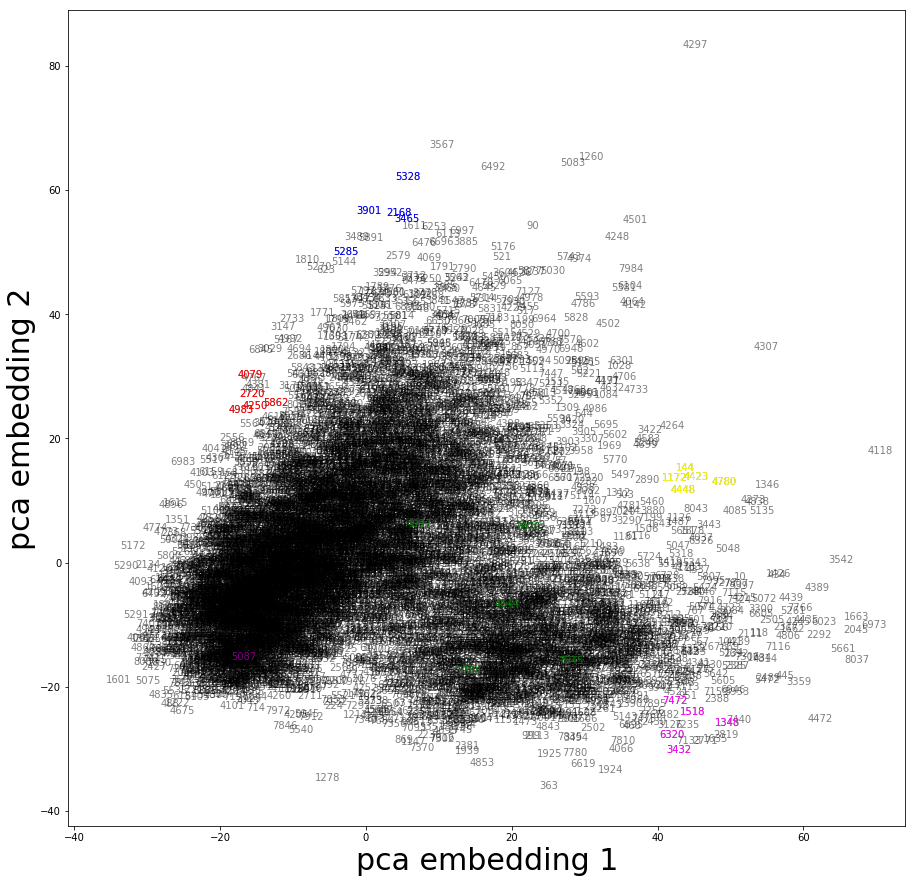

In [19]:
# pick some related images that will form a cluster for visualization
picked_pic = OrderedDict()
picked_pic["red"]     = [2720,4250,4983,5862,4079]
picked_pic["green"]   = [2070,3784,7545,4644, 4997]
picked_pic["magenta"] = [6320,3432,1348,7472, 1518]
picked_pic["blue"]    = [3901,2168,3465,5285,5328]
picked_pic["yellow"]  = [144,1172,4423,4780,4448]
picked_pic["purple"]  = [5087]

fix, ax = plt.subplots(figsize=(15, 15))
ax.scatter(y_pca[:, 0], y_pca[:, 1], c='white')

for irow in range(y_pca.shape[0]):
    ax.annotate(irow, y_pca[irow, :], color="black", alpha=0.5) 
    
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow, y_pca[irow, :], color=color)
        
ax.set_xlabel("pca embedding 1", fontsize=30)
ax.set_ylabel("pca embedding 2", fontsize=30)
plt.show()

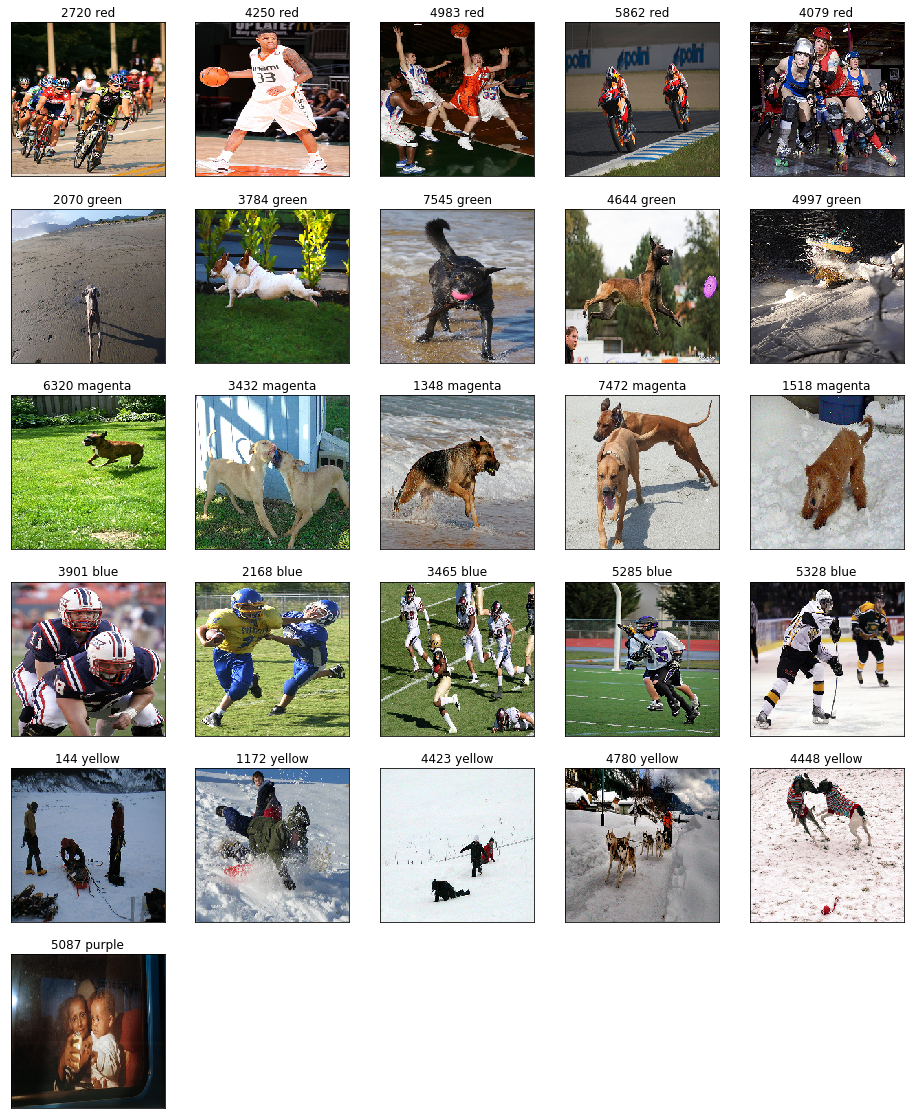

In [20]:
# plot the images
fig = plt.figure(figsize=(16, 20))
count = 1

for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = dir_flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        
        ax = fig.add_subplot(len(picked_pic), 5, count, xticks=[], yticks=[])
        
        count += 1
        
        plt.imshow(image)
        plt.title("{} {}".format(ivec, color))

plt.show()

## Merge the images and captions for training

In [20]:
# dimages are the actual features of the images, keep_index are the indexes kept in the df
dimages, keep_index = [], []

# create a df where only first caption is taken for processing
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0", :] # index 0 represents first caption
for i, fnm in enumerate(df_txt0.filename):
    if fnm in imgs.keys(): # check if fnm in keys of the imgs dictionary
        dimages.append(imgs[fnm])
        keep_index.append(i)
        
# fnames are the names of the image files
fnames = df_txt0["filename"].iloc[keep_index].values

# dcaptions are the captions of the images
dcaptions = df_txt0["caption"].iloc[keep_index].values

# dimages are the actual features of the images
dimages = np.array(dimages)

In [21]:
df_txt0[:5]

filename index  \
0   1000268201_693b08cb0e.jpg     0   
5   1001773457_577c3a7d70.jpg     0   
10  1002674143_1b742ab4b8.jpg     0   
15  1003163366_44323f5815.jpg     0   
20  1007129816_e794419615.jpg     0   

                                              caption  
0   startseq  child in pink dress is climbing up s...  
5   startseq  black dog and spotted dog are fighti...  
10  startseq  little girl covered in paint sits in...  
15  startseq  man lays on bench while his dog sits...  
20  startseq  man in an orange hat starring at som...

In [22]:
gc.collect()

60

## Tokenizing the captions for further processing
Convert captions to vectors for processing.

In [23]:
from keras.preprocessing.text import Tokenizer

# maximum number of words in the dictionary
nb_words = 6000
tokenizer = Tokenizer(nb_words=nb_words)

In [24]:
tokenizer.fit_on_texts(dcaptions)

vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))

dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


## Split the training and testing dataset

In [25]:
# propotion of test and val dataset
prop_test = 0.2
prop_val = 0.2

N = len(dtexts)
Ntest = int(N*prop_test)
Nval = int(N*prop_val)

def split_test_val_train(dtexts, Ntest, Nval):
    return dtexts[:Ntest], dtexts[Ntest:Ntest+Nval], dtexts[Ntest+Nval:]

# divide dataset for texts
dt_test, dt_val, dt_train = split_test_val_train(dtexts, Ntest, Nval)

# divide dataset for images
di_test, di_val, di_train = split_test_val_train(dimages, Ntest, Nval)

# divide dataset for filename of images
fnm_test, fnm_val, fnm_train = split_test_val_train(fnames, Ntest, Nval)

## Finding the max length of the caption

In [26]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

30


## Processing the captions and images

In [27]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts, dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))
    
    assert(N==len(dimages)) # make sure length of images and captions are similar
    
    Xtext, Ximage, ytext = [], [], []
    
    for text, image in zip(dtexts, dimages):
        for i in range(1, len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text], maxlen=maxlen).flatten() # use pad_sequences to make the length of call captions equal
            out_text = to_categorical(out_text, num_classes=vocab_size)
            
            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)
            
    Xtext = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext = np.array(ytext)
    print("{} {} {}".format(Xtext.shape, Ximage.shape, ytext.shape))
    
    return Xtext, Ximage, ytext

Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train, di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val, di_val)

# captions/images = 4855
(49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
(16353, 30) (16353, 4096) (16353, 4476)


## Build the LSTM model

In [28]:
from keras import layers
from keras.layers import Input, Flatten, Dropout, Activation

print(vocab_size)

# image feature
dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256, activation='relu', name='ImageFeature')(input_image)

# sequence model
input_txt = layers.Input(shape=(maxlen, ))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature", return_sequences=True)(ftxt)
se2 = Dropout(0.04)(ftxt)
ftxt = layers.LSTM(256, name="CaptureFeature2")(se2)

# combined model for decoder 
decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation='relu')(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

4476
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 64)       286464      input_3[0][0]                    
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 30, 256)      328704      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 30, 256)      0           CaptionFeature[0][0]   

 ## Train the LSTM model

In [29]:
# fit the model
from time import time
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

hist = model.fit([Ximage_train, Xtext_train], ytext_train,
                epochs=6, verbose=2,
                batch_size=32,
                validation_data=([Ximage_val, Xtext_val], ytext_val), callbacks=[tensorboard])

Instructions for updating:
Use tf.cast instead.
Train on 49631 samples, validate on 16353 samples
Epoch 1/6
 - 149s - loss: 5.3983 - val_loss: 4.9385
Epoch 2/6
 - 149s - loss: 4.5464 - val_loss: 4.5996
Epoch 3/6
 - 156s - loss: 4.1378 - val_loss: 4.4974
Epoch 4/6
 - 155s - loss: 3.8826 - val_loss: 4.4479
Epoch 5/6
 - 156s - loss: 3.6855 - val_loss: 4.4664
Epoch 6/6
 - 156s - loss: 3.5151 - val_loss: 4.4415


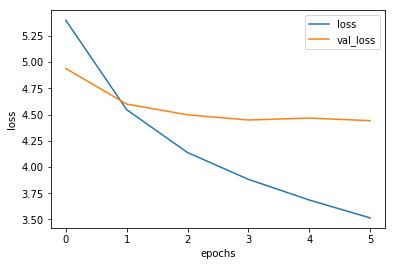

In [30]:
for label in ["loss", "val_loss"]:
    plt.plot(hist.history[label], label=label)

plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Generating captions on a set of images

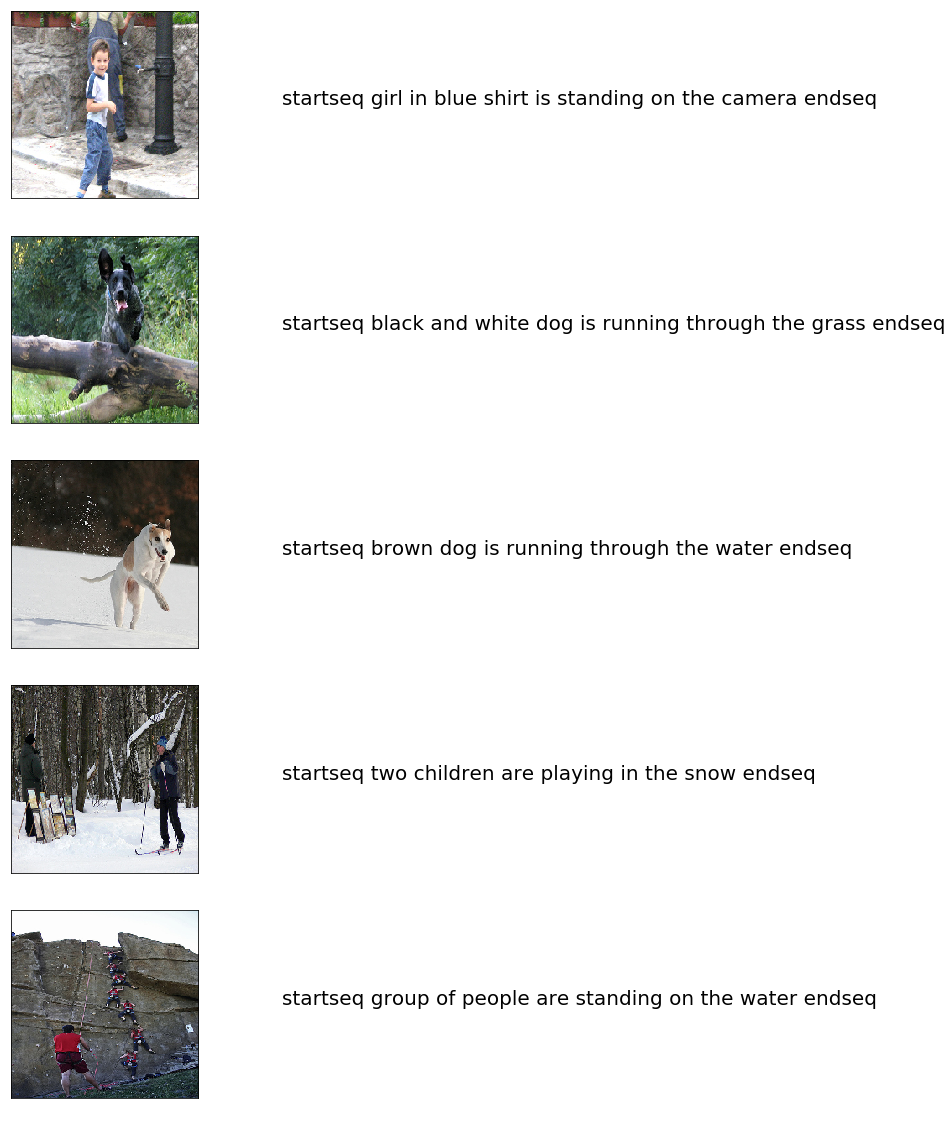

In [32]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[8:13],di_test[8:13]):
    ## images 
    filename = dir_flickr_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

## Generating captions for the whole test data and evaluating by BLEU Score

In [37]:
index_word = dict([(index, word) for word, index in tokenizer.word_index.items()])

n_keep = 5
pred_good, pred_bad, bleus = [], [], []
count = 0

for jpgfnm, image_feature, tokenized_text in zip(fnm_test, di_test, dt_test):
    count += 1
    if count % 200 == 0:
        print("   {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
        
    caption_true = [index_word[i] for i in tokenized_text]
    caption_true = caption_true[1:-1] # remove startseq, endseq
    
    # captions 
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]
    
    bleu = sentence_bleu([caption_true], caption)
    bleus.append(bleu)
    
    if bleu > 0.7 and len(pred_good) < n_keep:
        pred_good.append((bleu, jpgfnm, caption_true, caption))
    elif bleu < 0.3 and len(pred_bad) < n_keep:
        pred_bad.append((bleu, jpgfnm, caption_true, caption))

   12.36% is done..
   24.72% is done..
   37.08% is done..
   49.44% is done..
   61.80% is done..
   74.17% is done..
   86.53% is done..
   98.89% is done..


In [38]:
# print BLEU Score
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.011


## Good and bad captions examples from the model

Bad caption


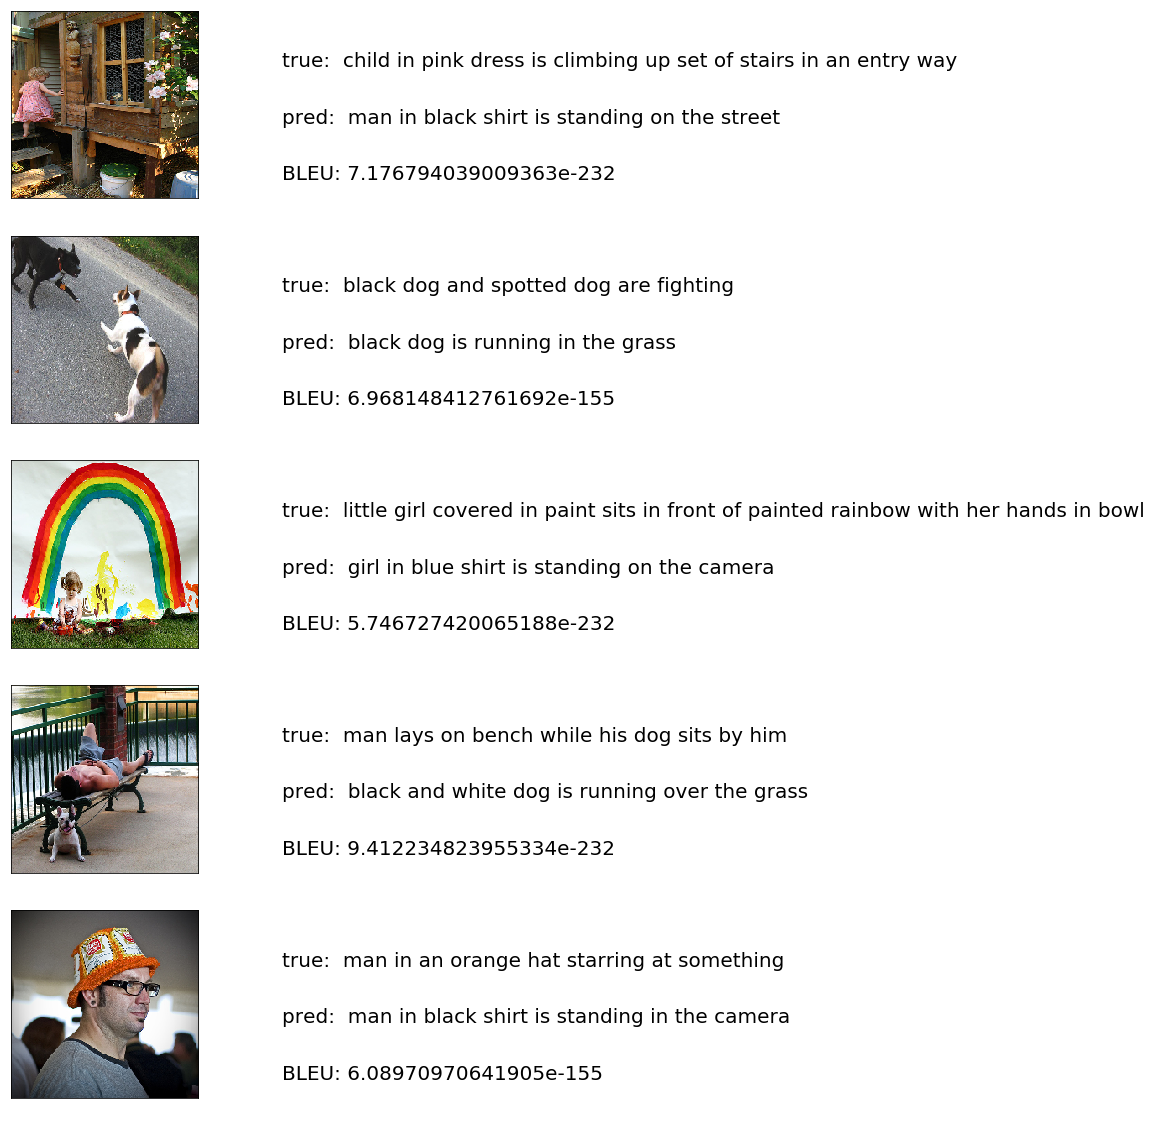

Good caption


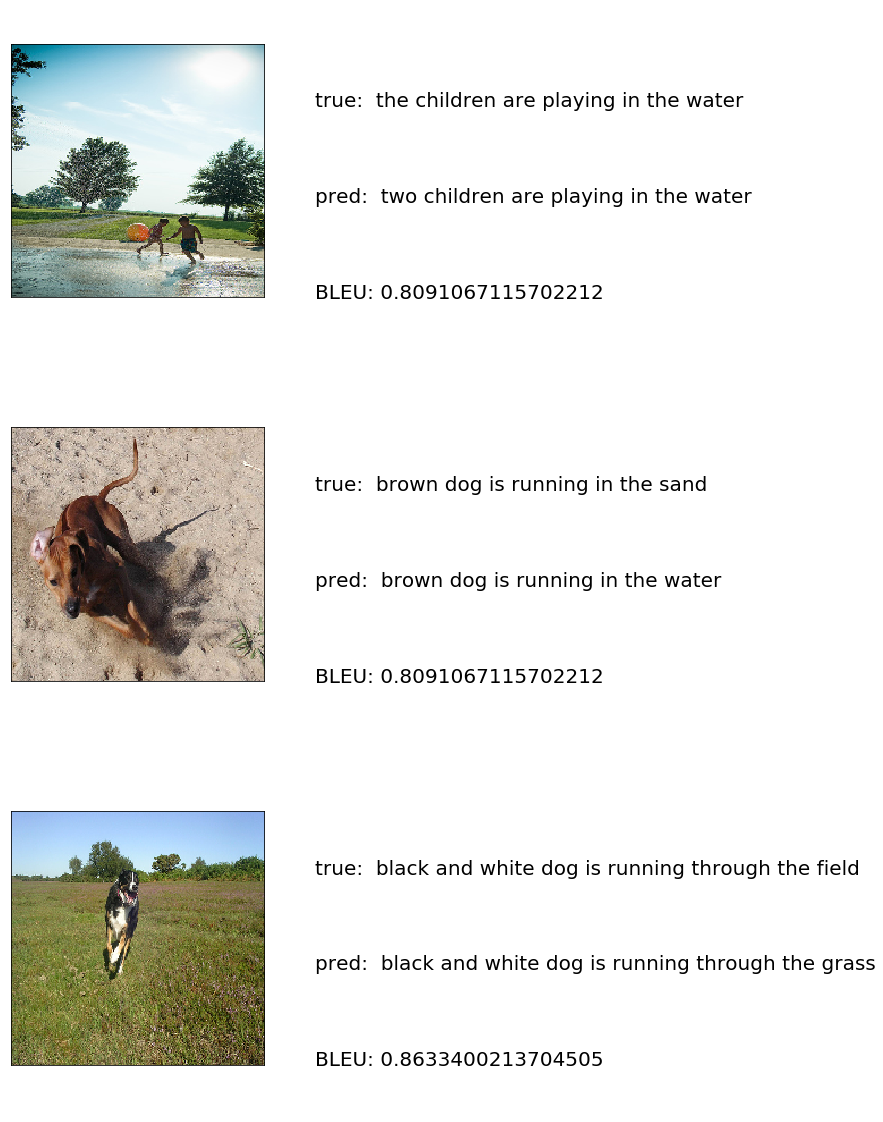

In [41]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
            
        return strue
    
    num_pix = 224
    target_size = (num_pix, num_pix, 3)
    
    count = 1
    fig = plt.figure(figsize=(10, 20))
    num_pic = len(pred_bad)
    for pb in pred_bad:
        bleu, jpgfnm, caption_true, caption = pb
        
        # images
        filename = dir_flickr_jpg + '/' + jpgfnm
        img_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(num_pic, 2, count, xticks=[], yticks=[])
        ax.imshow(img_load)
        
        count += 1
        
        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(num_pic, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.text(0, 0.7, "true: " + caption_true, fontsize=20)
        ax.text(0, 0.4, "pred: " + caption, fontsize=20)
        ax.text(0, 0.1, "BLEU: {}".format(bleu), fontsize=20)
        
        count += 1
    plt.show()
    
print("Bad caption")
plot_images(pred_bad)

print("Good caption")
plot_images(pred_good)